In [159]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, roc_auc_score
from keras.callbacks import TensorBoard

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/patient-survival-detection-dataset/Patient Survival Detection/Data Dictionary.csv
/kaggle/input/patient-survival-detection-dataset/Patient Survival Detection/Dataset.csv


In [2]:
# Using vaex to pre-process the large datasets
import vaex

In [3]:
df = pd.read_csv('/kaggle/input/patient-survival-detection-dataset/Patient Survival Detection/Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [4]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [5]:
df.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [6]:
df['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [7]:
df[df['hospital_death'].isna()]

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem


In [8]:
df.isnull().sum()[df.isnull().sum() != 0]

age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 175, dtype: int64

In [9]:
df.isnull().mean()*100

encounter_id                   0.000000
patient_id                     0.000000
hospital_id                    0.000000
hospital_death                 0.000000
age                            4.610033
                                 ...   
leukemia                       0.779606
lymphoma                       0.779606
solid_tumor_with_metastasis    0.779606
apache_3j_bodysystem           1.812175
apache_2_bodysystem            1.812175
Length: 186, dtype: float64

In [10]:
# percentage of rows with missing values
df.isnull().any(axis=1).sum()/len(df.index)

0.99972741050887

In [11]:
# loading dataframe using vaex
ndf = vaex.from_csv_arrow('/kaggle/input/patient-survival-detection-dataset/Patient Survival Detection/Dataset.csv')
ndf.info()

column,type,unit,description,expression
encounter_id,int64,,,
patient_id,int64,,,
hospital_id,int64,,,
hospital_death,int64,,,
age,int64,,,
bmi,float64,,,
elective_surgery,int64,,,
ethnicity,str,,,
gender,str,,,
height,float64,,,


- Filtering subdataset to select key columns
- Remove vitamins columns to reduce dataset

In [12]:
kdf = df.iloc[:,:19]
kdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   encounter_id           91713 non-null  int64  
 1   patient_id             91713 non-null  int64  
 2   hospital_id            91713 non-null  int64  
 3   hospital_death         91713 non-null  int64  
 4   age                    87485 non-null  float64
 5   bmi                    88284 non-null  float64
 6   elective_surgery       91713 non-null  int64  
 7   ethnicity              90318 non-null  object 
 8   gender                 91688 non-null  object 
 9   height                 90379 non-null  float64
 10  hospital_admit_source  70304 non-null  object 
 11  icu_admit_source       91601 non-null  object 
 12  icu_id                 91713 non-null  int64  
 13  icu_stay_type          91713 non-null  object 
 14  icu_type               91713 non-null  object 
 15  pr

In [13]:
fdf = pd.concat([kdf, df[['aids','diabetes_mellitus']]], axis=1)
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   encounter_id           91713 non-null  int64  
 1   patient_id             91713 non-null  int64  
 2   hospital_id            91713 non-null  int64  
 3   hospital_death         91713 non-null  int64  
 4   age                    87485 non-null  float64
 5   bmi                    88284 non-null  float64
 6   elective_surgery       91713 non-null  int64  
 7   ethnicity              90318 non-null  object 
 8   gender                 91688 non-null  object 
 9   height                 90379 non-null  float64
 10  hospital_admit_source  70304 non-null  object 
 11  icu_admit_source       91601 non-null  object 
 12  icu_id                 91713 non-null  int64  
 13  icu_stay_type          91713 non-null  object 
 14  icu_type               91713 non-null  object 
 15  pr

- Removing redundant columns from the dataset

In [14]:
mdf = fdf.drop(['encounter_id','patient_id','readmission_status'], axis=1)
target = fdf['hospital_death']

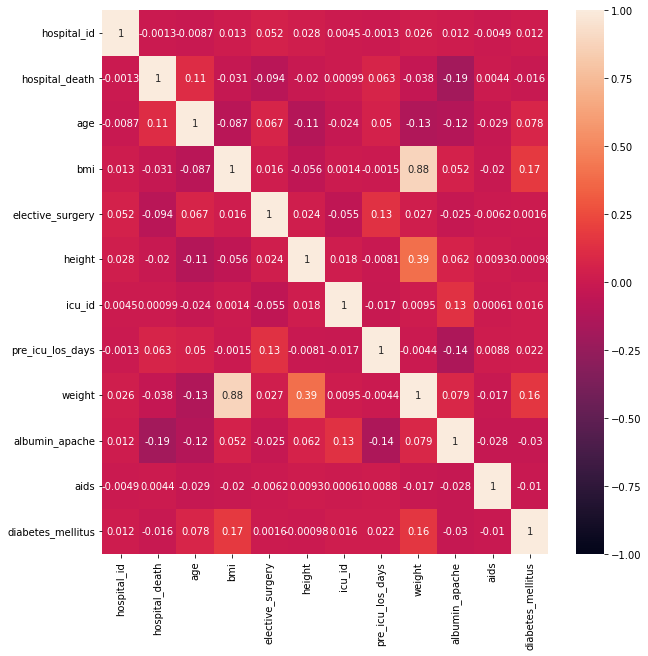

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(mdf.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

## Handling missing values

In [16]:
# let's check the albumin missing values
mdf['albumin_apache'].isnull().sum()/len(mdf['albumin_apache'])

0.5929257575261958

In [17]:
mdf['age']= mdf['age'].fillna(mdf['age'].mean())
mdf['bmi']= mdf['bmi'].fillna(mdf['bmi'].mean())
mdf['height']= mdf['height'].fillna(mdf['height'].mean())
mdf['weight'].fillna(mdf['weight'].mean(), inplace=True)

In [18]:
# handling missing values by most recurring values
mdf['hospital_admit_source'].replace(np.nan, 'Emergency Department', inplace=True)
mdf['icu_admit_source'].replace(np.nan,'Accident & Emergency', inplace=True)
mdf.drop('albumin_apache', axis=1, inplace=True)

In [19]:
# drop all the rows with missing values 
mdf.dropna(inplace=True, axis=0)
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89596 entries, 0 to 91712
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hospital_id            89596 non-null  int64  
 1   hospital_death         89596 non-null  int64  
 2   age                    89596 non-null  float64
 3   bmi                    89596 non-null  float64
 4   elective_surgery       89596 non-null  int64  
 5   ethnicity              89596 non-null  object 
 6   gender                 89596 non-null  object 
 7   height                 89596 non-null  float64
 8   hospital_admit_source  89596 non-null  object 
 9   icu_admit_source       89596 non-null  object 
 10  icu_id                 89596 non-null  int64  
 11  icu_stay_type          89596 non-null  object 
 12  icu_type               89596 non-null  object 
 13  pre_icu_los_days       89596 non-null  float64
 14  weight                 89596 non-null  float64
 15  ai

## EDA

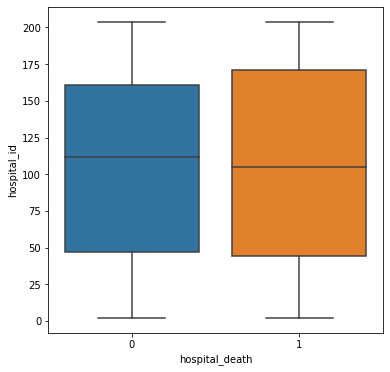

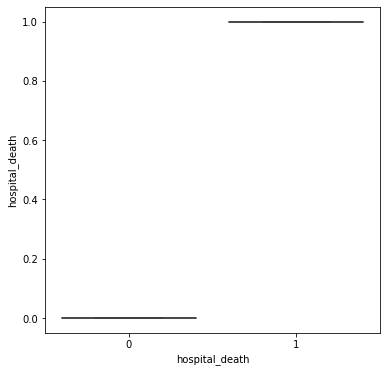

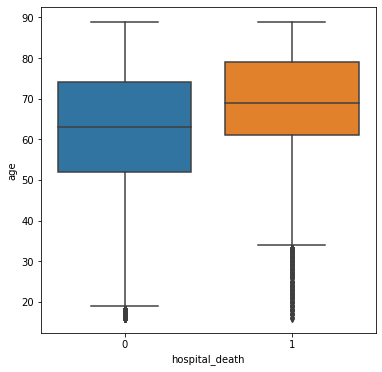

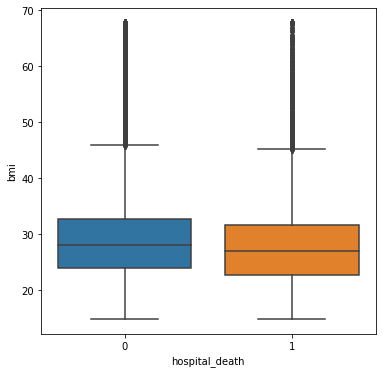

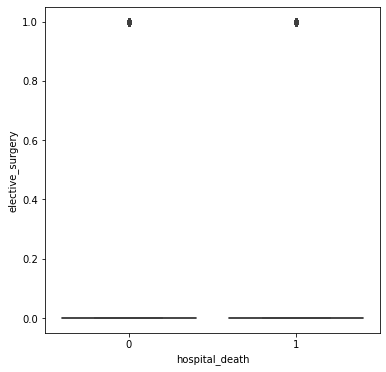

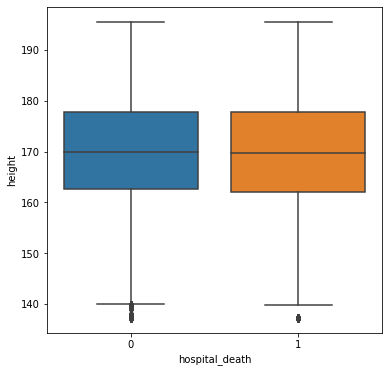

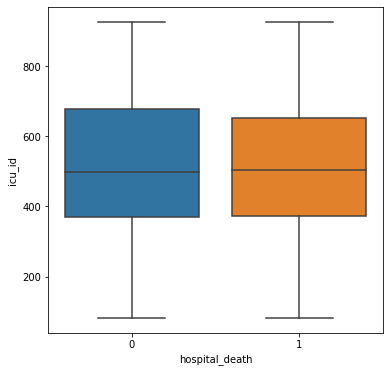

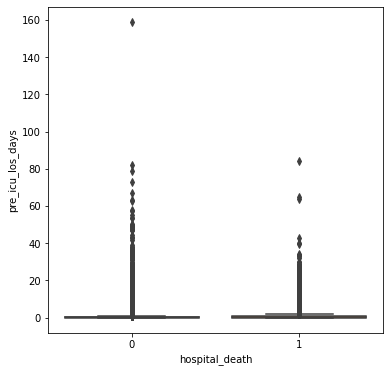

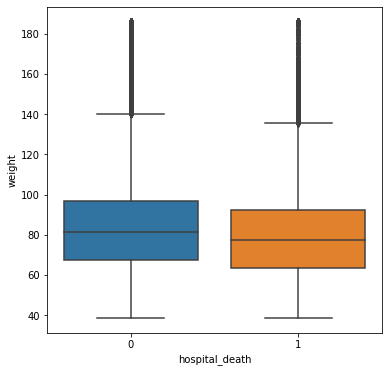

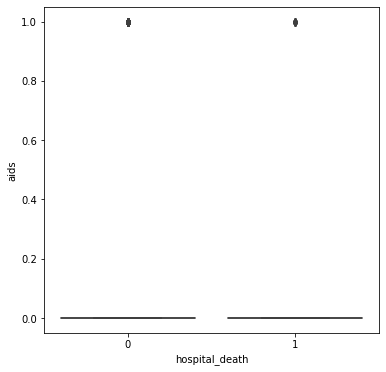

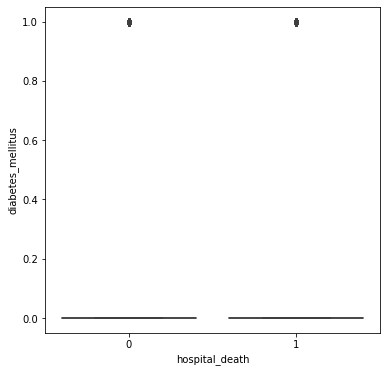

In [20]:
for i, col in enumerate(list(mdf.dtypes[mdf.dtypes != 'object'].index)):
    plt.figure(figsize=(6,6))
    sns.boxplot(x='hospital_death', y=col, data=mdf)
    plt.show()

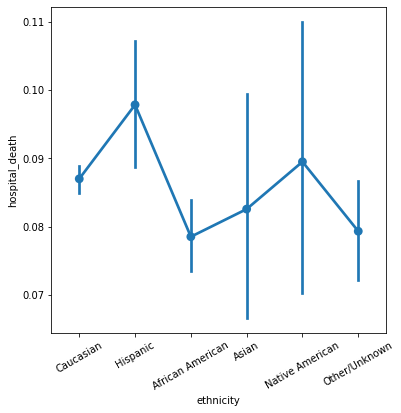

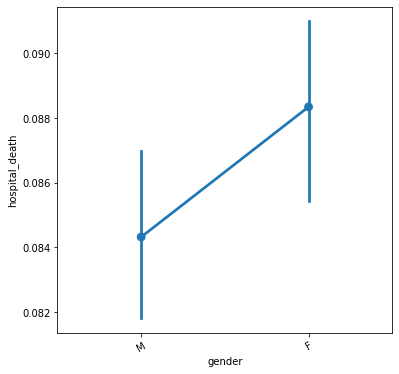

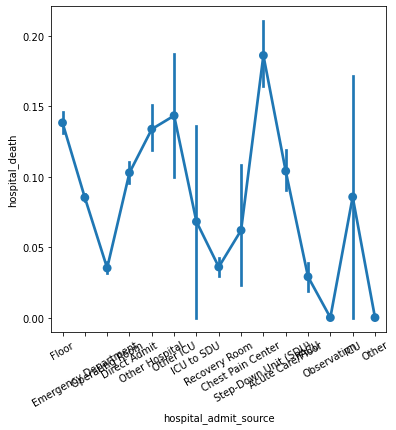

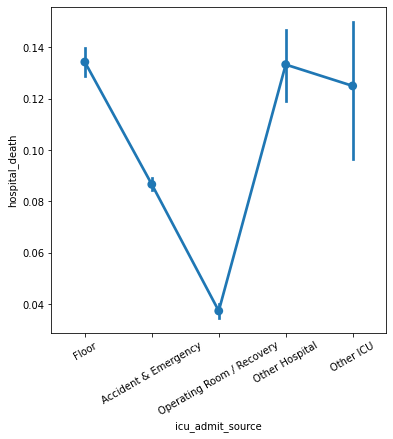

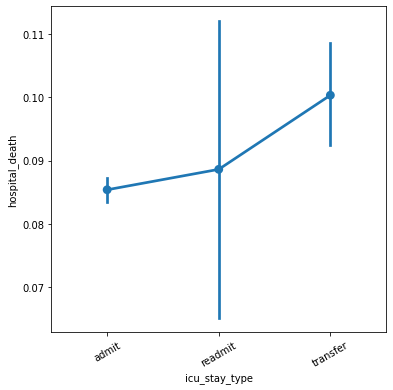

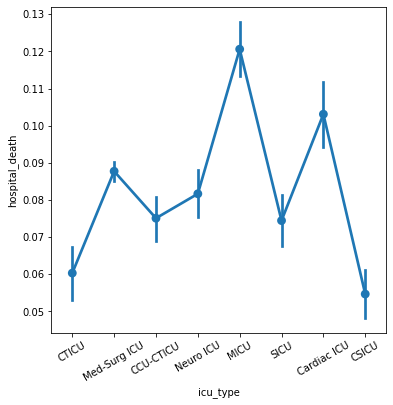

In [21]:
for col in list(mdf.dtypes[mdf.dtypes == 'object'].index):
    plt.figure(figsize=(6,6))
    sns.pointplot(y='hospital_death', x=col, data=mdf)
    plt.xticks(rotation=30)
    plt.show()

### Conclusions:

- Numerical columns are not indicative of target columns
- Categorical columns represent target variable more than numerical columns

### Next steps:

- Feature encoding
- Imbalance data treatment
- Select KBest features
- Feature scaling/transformation 
- NN modeling

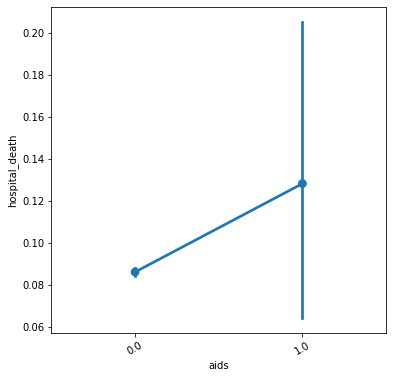

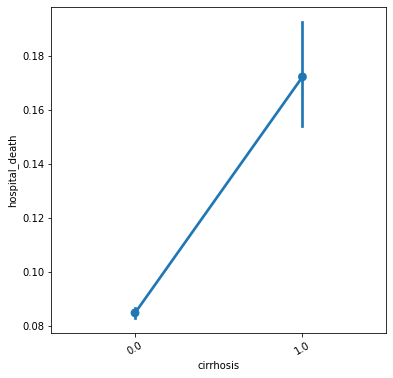

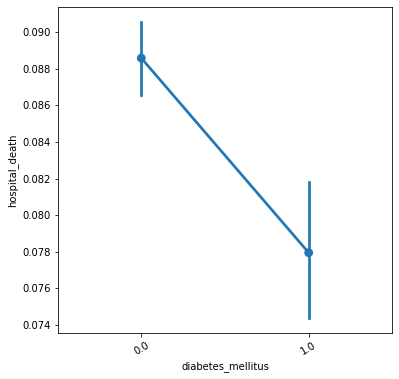

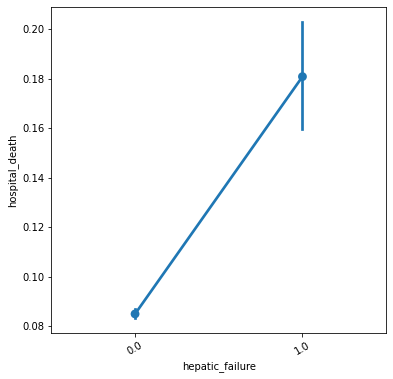

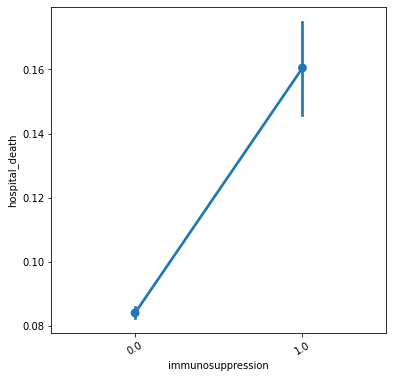

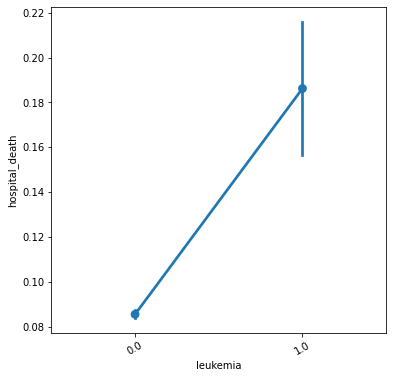

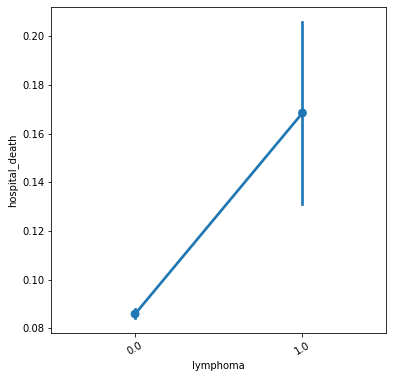

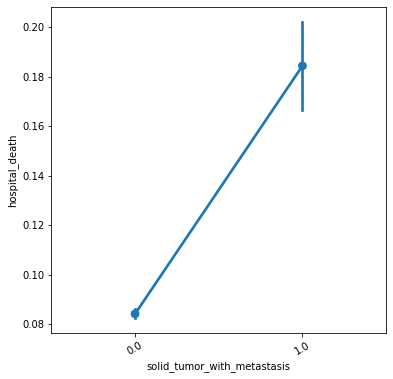

In [22]:
# check out aids to tumor columns for death cases
ldf = df.loc[:,'aids':'solid_tumor_with_metastasis']
for col in list(ldf.columns):
    plt.figure(figsize=(6,6))
    sns.pointplot(y=mdf['hospital_death'], x=col, data=ldf)
    plt.xticks(rotation=30)
    plt.show()

In [23]:
# final dataframe to append to mdf
cleand_ldf = ldf.dropna(axis=0)

In [24]:
# merge mdf and cleand_ldf on common indices
new_df = mdf.join(cleand_ldf, on=mdf.index, lsuffix='mdf', rsuffix='ldf')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89596 entries, 0 to 91712
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hospital_id                  89596 non-null  int64  
 1   hospital_death               89596 non-null  int64  
 2   age                          89596 non-null  float64
 3   bmi                          89596 non-null  float64
 4   elective_surgery             89596 non-null  int64  
 5   ethnicity                    89596 non-null  object 
 6   gender                       89596 non-null  object 
 7   height                       89596 non-null  float64
 8   hospital_admit_source        89596 non-null  object 
 9   icu_admit_source             89596 non-null  object 
 10  icu_id                       89596 non-null  int64  
 11  icu_stay_type                89596 non-null  object 
 12  icu_type                     89596 non-null  object 
 13  pre_icu_los_days

### Encoding categorical columns

In [66]:
X_new = new_df.drop('hospital_death', axis=1)
tar = new_df['hospital_death']

In [26]:
X_new = X_new.reset_index()
X_new_rein = X_new.drop('index', axis=1)

In [27]:
columns = ['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type']

encoder = OrdinalEncoder()
encoder.fit(X_new_rein[columns])
encoded_X = encoder.transform(X_new_rein[columns])
encoded_df = pd.DataFrame(encoded_X, columns=X_new_rein[columns].columns, index=X_new_rein.index)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89596 entries, 0 to 89595
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ethnicity              89596 non-null  float64
 1   gender                 89596 non-null  float64
 2   hospital_admit_source  89596 non-null  float64
 3   icu_admit_source       89596 non-null  float64
 4   icu_stay_type          89596 non-null  float64
 5   icu_type               89596 non-null  float64
dtypes: float64(6)
memory usage: 4.1 MB


In [28]:
X_new_rein[columns] = encoded_df
# FINAL DATAFRAME FOR FURTHER data balancing and modeling 
#X_nn = X_new_rein.drop('level_0', axis=1)
X_new_rein.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89596 entries, 0 to 89595
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hospital_id                  89596 non-null  int64  
 1   age                          89596 non-null  float64
 2   bmi                          89596 non-null  float64
 3   elective_surgery             89596 non-null  int64  
 4   ethnicity                    89596 non-null  float64
 5   gender                       89596 non-null  float64
 6   height                       89596 non-null  float64
 7   hospital_admit_source        89596 non-null  float64
 8   icu_admit_source             89596 non-null  float64
 9   icu_id                       89596 non-null  int64  
 10  icu_stay_type                89596 non-null  float64
 11  icu_type                     89596 non-null  float64
 12  pre_icu_los_days             89596 non-null  float64
 13  weight          

In [70]:
# change the indices of the target variable
tar.index = X_new_rein.index

## Upsampling to balance the dataset

In [97]:
# smote upsampling and feature selection, then modeling
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_res ,y_res = smote.fit_resample(X_new_rein, tar)

## Feature selection function

In [114]:
def feature_sel(method, features):
    if method==f_classif:
        fse = SelectKBest(f_classif, k=features)
        X_ne = fse.fit_transform(X_res,y_res)
    if method==chi2:
        fse = SelectKBest(chi2, k=features)
        X_ne = fse.fit_transform(X_res,y_res)
    return pd.DataFrame(X_ne, columns = fse.get_feature_names_out())

In [127]:
X_ne = feature_sel(f_classif,12)
X_ne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163750 entries, 0 to 163749
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          163750 non-null  float64
 1   bmi                          163750 non-null  float64
 2   elective_surgery             163750 non-null  float64
 3   hospital_admit_source        163750 non-null  float64
 4   icu_admit_source             163750 non-null  float64
 5   pre_icu_los_days             163750 non-null  float64
 6   weight                       163750 non-null  float64
 7   cirrhosis                    163750 non-null  float64
 8   hepatic_failure              163750 non-null  float64
 9   immunosuppression            163750 non-null  float64
 10  leukemia                     163750 non-null  float64
 11  solid_tumor_with_metastasis  163750 non-null  float64
dtypes: float64(12)
memory usage: 15.0 MB


## Modeling using NNs

In [133]:
# standardize the dataset
scaler = StandardScaler()
X_fi = scaler.fit_transform(X_ne)
X_fi = pd.DataFrame(X_fi, columns=X_ne.columns)

In [147]:
# train and test split
X_trn, X_tst, y_trn, y_tst = train_test_split(X_fi, y_res, test_size=0.25, random_state=42)

In [149]:
# NN
model = Sequential()
model.add(Dense(64, input_dim=12, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 6,113
Trainable params: 6,113
Non-trainable params: 0
____________________________________________________

In [150]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Tensorboard Visualization

In [151]:
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
model.fit(X_trn, y_trn, epochs=50, batch_size=128, callbacks=[tb_callback])

2022-12-15 13:05:26.789941: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-15 13:05:26.790019: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-15 13:05:26.790928: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/50
 28/960 [..............................] - ETA: 6s - loss: 0.6724 - accuracy: 0.6317

2022-12-15 13:05:27.900630: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-15 13:05:27.900928: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-15 13:05:27.908360: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-15 13:05:27.914451: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-15 13:05:27.926540: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_12_15_13_05_27

2022-12-15 13:05:27.928087: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_12_15_13_05_27/8f64f7fe7069.trace.json.gz
2022-12-15 13:05:27.943477: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_12_15_13_05_27

2022-12-15 13:05:27.944

960/960 [==============================] - 5s 4ms/step - loss: 0.5593 - accuracy: 0.6924
Epoch 2/50
960/960 [==============================] - 4s 4ms/step - loss: 0.4857 - accuracy: 0.7288
Epoch 3/50
960/960 [==============================] - 4s 4ms/step - loss: 0.4662 - accuracy: 0.7376
Epoch 4/50
960/960 [==============================] - 4s 4ms/step - loss: 0.4584 - accuracy: 0.7409
Epoch 5/50
960/960 [==============================] - 4s 4ms/step - loss: 0.4535 - accuracy: 0.7454
Epoch 6/50
960/960 [==============================] - 4s 4ms/step - loss: 0.4499 - accuracy: 0.7466
Epoch 7/50
960/960 [==============================] - 4s 4ms/step - loss: 0.4458 - accuracy: 0.7508
Epoch 8/50
960/960 [==============================] - 4s 4ms/step - loss: 0.4414 - accuracy: 0.7538
Epoch 9/50
960/960 [==============================] - 4s 5ms/step - loss: 0.4356 - accuracy: 0.7598
Epoch 10/50
960/960 [==============================] - 4s 4ms/step - loss: 0.4312 - accuracy: 0.7639
Epoch 11/5

In [164]:
preds = model.predict(X_tst)
pred = list()
for i in range(len(preds)):
    pred.append(np.argmax(preds[i]))
acc = accuracy_score(y_tst, pred)
roc_auc = roc_auc_score(y_tst, pred)
print("Accuracy score:", acc)
print("ROC AUC score:", roc_auc)

Accuracy score: 0.49670233035321704
ROC AUC score: 0.5
